# 4) Pretraining LLMs

In [3]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.3
numpy version: 1.26.4
tiktoken version: 0.9.0
torch version: 2.7.1


- In this notebook, we implement the training loop and code for basic model evaluation to pretrain an LLM

<img src="figures/01.png" width=1000px>

<br>
<br>
<br>
<br>



# 4.1 Using GPT to generate text

- We initialize a GPT model using the code from the previous notebook

In [4]:
import torch
from supplementary import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- We use dropout of 0.1 above, but it's relatively common to train LLMs without dropout nowadays
- Modern LLMs also don't use bias vectors in the `nn.Linear` layers for the query, key, and value matrices (unlike earlier GPT models), which is achieved by setting `"qkv_bias": False`
- We reduce the context length (`context_length`) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

- Next, we use the `generate_text_simple` function from the previous chapter to generate text
- In addition, we define two convenience functions, `text_to_token_ids` and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter

<img src="figures/02.png" width=1200px>

In [5]:
import tiktoken
from supplementary import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [6]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- As we can see above, the model does not produce good text because it has not been trained yet
- How do we measure or capture what "good text" is, in a numeric form, to track it during training?
- The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress
- The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

<br>

<br>
<br>
<br>
<br>



# 4.2 Preparing the dataset loaders

- We use a relatively small dataset for training the LLM (in fact, only one short story)
  - The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes
- For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens
 
- Below, we use the same dataset we used in the data preparation notebook earlier

In [7]:
with open("the-verdict.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

- A quick check that the text loaded ok by printing the first and last 100 words

In [8]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [9]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [10]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later)

- Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training
- For visualization purposes, the figure below assumes a `max_length=6`, but for the training loader, we set the `max_length` equal to the context length that the LLM supports
- The figure below only shows the input tokens for simplicity
    - Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position

<img src="figures/03.png" width=1500px>

In [11]:
from supplementary import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

- We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with
- Llama 2 7B was trained with a batch size of 1024, for example

- An optional check that the data was loaded correctly:

In [12]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- Another optional check that the token sizes are in the expected ballpark:

In [13]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- Next, let's calculate the initial loss before we start training

- If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
- Via the `device` setting, we ensure that the data is loaded onto the same device as the LLM model

In [14]:
from supplementary import calc_loss_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


<br>
<br>
<br>
<br>



# 4.3 Training an LLM

- In this section, we finally implement the code for training the LLM

<img src="figures/04.png" width=700px>

In [15]:
from supplementary import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

- Now, let's train the LLM using the training function defined above:

In [16]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

In [17]:
torch.save(model.state_dict(), "model.pth")

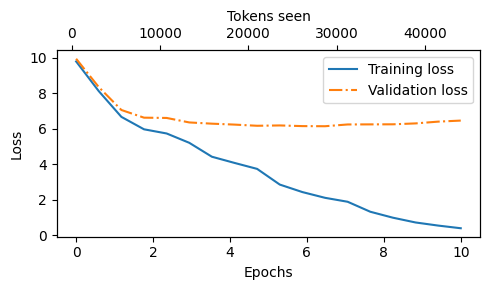

In [18]:
from supplementary import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences
- However, based on the training and validation set losses, we can see that the model starts overfitting
- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data

- There are decoding strategies (not covered in this workshop) that can mitigate this memorization by a certain degree
- Also note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times
  - The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
  - Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load pretrained weights later

<br>
<br>
<br>
<br>



# Exercise 1: Generate text from the pretrained LLM

- Use the model to generate new text (HINT: scroll up to see how we generated text before)

<br>
<br>
<br>
<br>



# Exercise 2: Load the pretrained model in a new session

- Open a new Python session or Jupyter notebook and load the model there

<br>
<br>
<br>
<br>


# Exercise 3 (Optional): Train the LLM on your own favorite texts